In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from sklearn.linear_model import Lasso, LinearRegression
import numpy as np
import exceptions
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [2]:
data = pd.read_csv('n_pickups_2015-12_2016-06.csv',  index_col = 0,
                   parse_dates=True)

In [3]:
test_end      = pd.to_datetime('2016-04-30 23')
train_end     = pd.to_datetime('2016-05-31 23')
predict_start = pd.to_datetime('2016-05-31 23')
predict_end   = pd.to_datetime('2016-06-30 17')
features = pd.DataFrame(index = data.index)
data.tail()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-30 19:00:00,116,190,135,132,395,308,401,336,496,260,...,2,44,4,297,311,104,9,142,96,1
2016-06-30 20:00:00,104,142,149,141,333,368,390,385,560,247,...,1,27,7,288,344,103,24,209,145,0
2016-06-30 21:00:00,151,162,145,135,359,422,460,541,672,259,...,2,21,9,287,307,185,9,213,142,1
2016-06-30 22:00:00,106,168,103,125,317,476,405,508,578,259,...,3,19,5,358,387,169,12,206,146,0
2016-06-30 23:00:00,85,130,86,113,256,428,483,531,631,210,...,9,0,7,323,110,147,38,173,119,0


Теперь создадим дополнительные признаки на основании периодических функций.

In [4]:
def harmonics(x_len, func, period, shift, factor):
    x = np.arange(1 + shift, x_len + shift + 1)
    try : 
        if func == 'sin':
            f = np.sin
        elif func == 'cos':
            f = np.cos
    except Exception:
        print "func must be 'sin' or 'cos'."
    return f(x * 2. * np.pi * float(factor)/float(period))

In [5]:
%%time
harmonics_names = []
periods   = [6, 12, 24, 168]
for period in periods:
    for shift in range (0, int(period/2), 2):
        for factor in range (1, int(period/2 + 1), 3):
            name = '{}_{}_{}_{}'.format('sin', int(period), shift, factor)
            harmonics_names.append(name)
            features[name] = harmonics(features.shape[0], 'sin', period, shift, factor)
features['trend_asc'] = np.arange(1, features.shape[0] + 1)
features['trend_des'] = features.trend_asc.values[::-1]

Wall time: 839 ms


In [6]:
%%time
lasso_scores = []
for col in data.columns:
    estimator = Lasso()
    X = features.loc[:test_end,:]
    y = data.loc[:test_end, col].astype('float32')
    estimator.fit(X, y, )
    lasso_scores.append(estimator.score(X,y))

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Wall time: 2min 39s


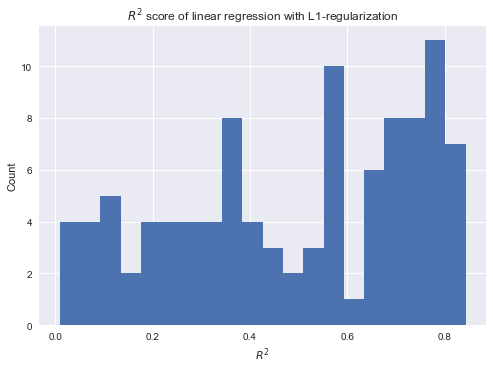

In [7]:
plt.hist(lasso_scores, bins = 20)
plt.xlabel('$R^2$')
plt.ylabel('Count')
plt.title('$R^2$ score of linear regression with L1-regularization')
plt.show()

In [8]:
holidays = calendar().holidays(start = features.index.min(), end = features.index.max()).floor('1D')

features['weekday'], features['hour'] = features.index, features.index
features['weekday']    = features.weekday.apply(lambda x: x.weekday())
features['hour']       = features.hour.apply(lambda x: x.hour)
features['holidays']   = features.index.floor('1D').isin(holidays)

In [9]:
diff_names = []
for col in data.columns:
    for diff in range (1, 49):
        name = 'diff_{}_{}'.format(col, diff)
        diff_names.append(name)
        npickups = data.loc[:, col]
        features[name] = npickups - npickups.shift(diff)

In [10]:
features.shape

(5112, 6109)

In [11]:
features = features.dropna(axis = 'rows')
features.shape

(5064, 6109)

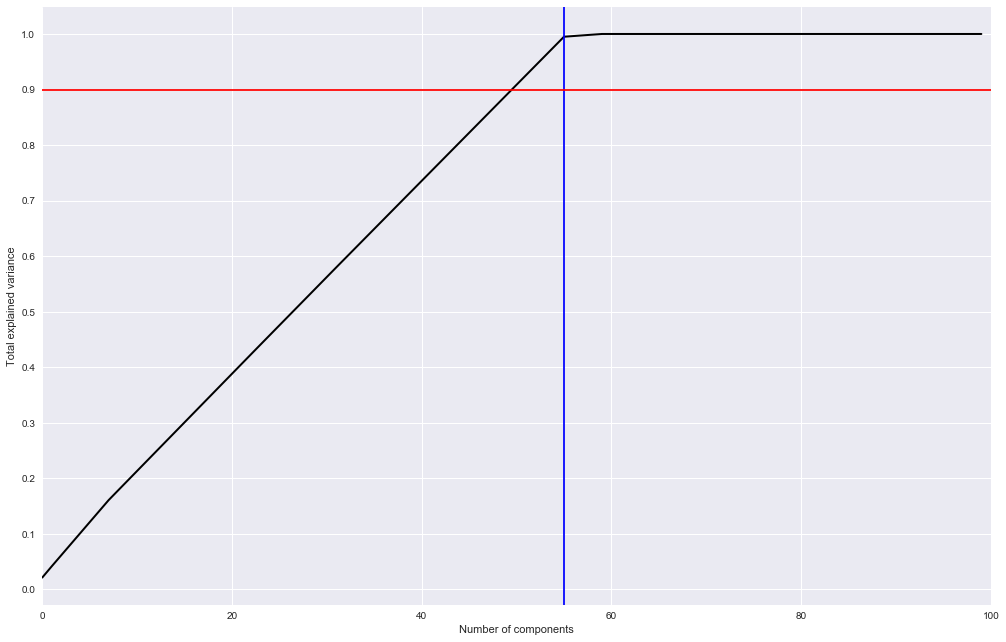

Wall time: 824 ms


In [12]:
%%time
pca_harmonics = PCA(n_components=100, svd_solver='randomized').fit(features.loc[:, harmonics_names])
plt.figure(figsize=(17,11))
plt.plot(np.cumsum(pca_harmonics.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(55, c='b')
plt.axhline(0.9, c='r')
plt.show();

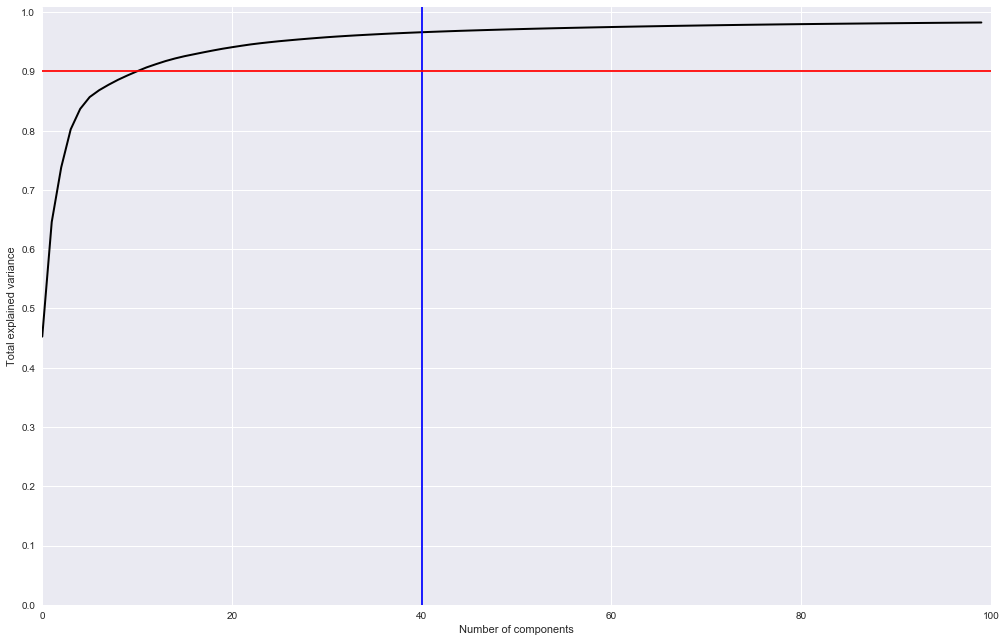

Wall time: 2.12 s


In [13]:
%%time
pca_diff = PCA(n_components=100, svd_solver='randomized').fit(features.loc[:, diff_names])
plt.figure(figsize=(17,11))
plt.plot(np.cumsum(pca_diff.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(40, c='b')
plt.axhline(0.9, c='r')
plt.show();

In [14]:
harmonics_decorr = PCA(n_components=55, svd_solver='randomized').fit_transform(features.loc[:, harmonics_names])
diff_decorr      = PCA(n_components=40, svd_solver='randomized').fit_transform(features.loc[:, diff_names])

In [15]:
features.drop(np.hstack((harmonics_names, diff_names)), axis = 'columns', inplace = True)
features.head()

,trend_asc,trend_des,weekday,hour,holidays
datetime,,,,,
2015-12-03 00:00:00,49,5064,3,0,False
2015-12-03 01:00:00,50,5063,3,1,False
2015-12-03 02:00:00,51,5062,3,2,False
2015-12-03 03:00:00,52,5061,3,3,False
2015-12-03 04:00:00,53,5060,3,4,False


In [16]:
for i, col in enumerate(harmonics_decorr.T):
    name = 'harmonics_decorr_{}'.format(i)
    features[name] = col
for i, col in enumerate(diff_decorr.T):
    name = 'diff_decorr_{}'.format(i)
    features[name] = col

In [17]:
features.head(3)

,trend_asc,trend_des,weekday,hour,holidays,harmonics_decorr_0,harmonics_decorr_1,harmonics_decorr_2,harmonics_decorr_3,harmonics_decorr_4,...,diff_decorr_30,diff_decorr_31,diff_decorr_32,diff_decorr_33,diff_decorr_34,diff_decorr_35,diff_decorr_36,diff_decorr_37,diff_decorr_38,diff_decorr_39
datetime,,,,,,,,,,,,,,,,,,,,,
2015-12-03 00:00:00,49,5064,3,0,False,2.598249,-4.448103,-3.822258,4.176153,2.261649,...,-56.918741,1457.996976,-476.825020,-336.077390,470.536670,-292.076406,-63.287412,134.788292,-300.902368,-342.421720
2015-12-03 01:00:00,50,5063,3,1,False,5.197106,0.000309,3.598168,5.983577,-2.996551,...,402.516758,376.137781,-933.110219,21.084986,205.487363,-261.621202,-30.093662,273.223532,184.103050,164.758330
2015-12-03 02:00:00,51,5062,3,2,False,2.598354,4.447239,-5.263867,2.598362,-2.619052,...,-86.891220,-264.688943,-109.317036,93.140681,-231.740751,94.406881,223.283407,-407.385177,697.959769,-411.532493


In [18]:
features['weekday'] = features.weekday.astype('category')
features['holidays'] = features.holidays.astype('category')
features = pd.get_dummies(features, drop_first=True)
features.head()

,trend_asc,trend_des,hour,harmonics_decorr_0,harmonics_decorr_1,harmonics_decorr_2,harmonics_decorr_3,harmonics_decorr_4,harmonics_decorr_5,harmonics_decorr_6,...,diff_decorr_37,diff_decorr_38,diff_decorr_39,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holidays_True
datetime,,,,,,,,,,,,,,,,,,,,,
2015-12-03 00:00:00,49,5064,0,2.598249,-4.448103,-3.822258,4.176153,2.261649,2.982628,5.311882,...,134.788292,-300.902368,-342.421720,0,0,1,0,0,0,0
2015-12-03 01:00:00,50,5063,1,5.197106,0.000309,3.598168,5.983577,-2.996551,2.256997,-3.555026,...,273.223532,184.103050,164.758330,0,0,1,0,0,0,0
2015-12-03 02:00:00,51,5062,2,2.598354,4.447239,-5.263867,2.598362,-2.619052,-5.621549,0.000074,...,-407.385177,697.959769,-411.532493,0,0,1,0,0,0,0
2015-12-03 03:00:00,52,5061,3,-2.599158,4.447860,1.503429,3.819849,6.553179,-0.173550,0.708774,...,-166.428098,-26.369371,-507.081951,0,0,1,0,0,0,0
2015-12-03 04:00:00,53,5060,4,-5.197913,-0.000305,-3.000475,1.080852,-3.251123,4.548512,-3.602363,...,182.278425,-537.284077,-319.252691,0,0,1,0,0,0,0


In [19]:
%%time
lasso_scores_decorr = []
for col in data.columns:
    estimator = Lasso()
    dt_min = features.index.min()
    X = features.loc[dt_min:test_end,:]
    y = data.loc[dt_min:test_end, col].astype('float32')
    estimator.fit(X, y, )
    lasso_scores_decorr.append(estimator.score(X,y))

Wall time: 6.15 s


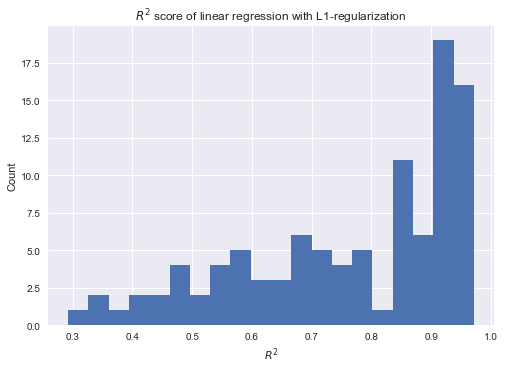

In [20]:
plt.hist(lasso_scores_decorr, bins = 20)
plt.xlabel('$R^2$')
plt.ylabel('Count')
plt.title('$R^2$ score of linear regression with L1-regularization')
plt.show()

Введение дополнительных признаков и их декорреляция положительно сказались на моделях, существенно увеличив их $R^2$.

Теперь загрузим предсказания аримы с прошлой недели.

In [21]:
arima_predictions = pd.read_csv('predictions.csv', parse_dates=True, index_col=0)

In [22]:
arima_predictions.head(3)

,1783_final_dt_1,1783_final_dt_2,1783_final_dt_3,1783_final_dt_4,1783_final_dt_5,1783_final_dt_6,1076_final_dt_1,1076_final_dt_2,1076_final_dt_3,1076_final_dt_4,...,1282_final_dt_3,1282_final_dt_4,1282_final_dt_5,1282_final_dt_6,1684_final_dt_1,1684_final_dt_2,1684_final_dt_3,1684_final_dt_4,1684_final_dt_5,1684_final_dt_6
2015-12-01 00:00:00,-28.315719,-51.358492,-48.410119,-58.562330,-65.317439,-23.680765,37.014835,26.328980,22.906059,30.888397,...,108.534313,122.172936,149.803229,297.544747,-3.258614,-4.847558,-5.545350,-5.444259,-4.655379,-3.359475
2015-12-01 01:00:00,-38.638788,-40.996399,-52.953780,-60.323034,-18.895300,62.512288,16.043214,15.698631,25.684783,41.974869,...,53.231456,81.816290,228.948552,508.557773,-4.062898,-5.045521,-4.977223,-4.192119,-2.896650,-1.307962
2015-12-01 02:00:00,-23.639469,-42.837238,-52.669774,-12.080084,69.042390,149.185107,17.724149,27.104101,42.999587,85.437216,...,135.558831,281.946991,562.031151,749.583314,-4.067192,-4.354028,-3.609810,-2.319049,-0.730903,0.949970


Теперь скомпонуем данные, соединив сгенерированные в предыдущих ячейках гармонические, линейные икалендарные декоррелированные и категориальные признаки с предсказаниями ARIMA + LinearRegression - моделей с прошлой части работы.

In [23]:
%%time
data_list  = []
for dt in range (1,7):
    names_arima = []
    for region in data.columns:
        name_arima = '{}_final_dt_{}'.format(region, dt) #Имя колонки с предсказанием аримы
        names_arima.append(name_arima)
    data_list.append(pd.concat([arima_predictions.loc[:, names_arima],
                                    features.shift(-dt), data.shift(-dt)],axis = 'columns'))

Wall time: 112 ms


Теперь мы имеем массив датафреймов для каждого $\Delta(t)$. Каждый датафрейм содержит фичи и отклики для них.
Нужно его очистить от образовавшихся из за shift'a NaN'ов. и разделить на фичи, предсказания арим и отклики.

In [24]:
data_list = map(lambda x: x.dropna(), data_list)
data_list[5].tail()
gen_features_list   = map(lambda x: x.loc[:, features.columns],          data_list)
arima_features_list = map(lambda x: x.loc[:, arima_predictions.columns], data_list)
response_list       = map(lambda x: x.loc[:, data.columns],              data_list)

Натренируем по модели на каждую $\Delta(t)$ для каждого региона. Будем использовать данные по по апрель включительно.

### 1, 2.
Для каждой из шести задач прогнозирования y^T+i|T,i=1,…,6 сформируйте выборки. Откликом будет yT+i при всевозможных значениях T, а признаки можно использовать следующие:


Разбейте каждую из шести выборок на три части:

In [31]:
%%time
data_dict = {}
for region in data.columns:
    dt_ = {}
    for dt in range(1,7):
        data_ = {}
        index = dt - 1
        
        name_arima = '{}_final_dt_{}'.format(region, dt)
        
        data_['X_test']    = pd.concat([arima_features_list[index].loc[:test_end,  name_arima],
                                          gen_features_list[index].loc[:test_end,  :]], axis = 'columns')
        data_['X_train']   = pd.concat([arima_features_list[index].loc[:train_end, name_arima],
                                          gen_features_list[index].loc[:train_end, :]], axis = 'columns')
        data_['X_may']     = pd.concat([arima_features_list[index].loc['2016-04-30 23':'2016-05-31 17', name_arima],
                                          gen_features_list[index].loc['2016-04-30 23':'2016-05-31 17', :]], axis = 'columns')
        data_['X_june']    = pd.concat([arima_features_list[index].loc['2016-05-31 23':'2016-06-30 17', name_arima],
                                          gen_features_list[index].loc['2016-05-31 23':'2016-06-30 17', :]], axis = 'columns')
        data_['y_test']  = response_list[index].loc[:test_end,   region]
        data_['y_train'] = response_list[index].loc[:train_end,  region]
        data_['y_may']  = response_list[index].loc['2016-04-30 23':'2016-05-31 17',   region]
        data_['y_june'] = response_list[index].loc['2016-05-31 23':'2016-06-30 17',   region]
        
        dt_[dt] = data_
    data_dict[region] = dt_

Wall time: 9.16 s


### 3. 
Выберите вашу любимую регрессионную модель и настройте её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. Желательно, чтобы модель:

In [33]:
%%time
distances = []
for region in data.columns:
    for dt in range(1, 7):
        X = data_dict[region][dt]['X_test']
        y = data_dict[region][dt]['y_test']
        estimator = Lasso()
        estimator.fit(X, y)
        y_prediction = estimator.predict(data_dict[region][dt]['X_may'])
        y_actual     = data_dict[region][dt]['y_may']
        distance = np.abs(y_actual - y_prediction)
        distances.append(distance)

Wall time: 41.8 s


### 4. 
Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу:

In [51]:
print('Q-метрика для мая составляет: {}'.format(round(pd.DataFrame(distances).sum().sum() / (739. * 6. * 102.), 3)))

Q-метрика для мая составляет: 14.582


Теперь обучим модели по май включительно и предскажем данные в июне.

### 5. 
Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [58]:
%%time
distances = []
predictions = pd.DataFrame()
for region in data.columns:
    for dt in range(1, 7):
        name = 'prediction_{}_dt_{}'.format(region, dt)
        X = data_dict[region][dt]['X_train']
        y = data_dict[region][dt]['y_train']
        estimator = Lasso()
        estimator.fit(X, y)
        y_prediction = estimator.predict(data_dict[region][dt]['X_june'])
        y_actual     = data_dict[region][dt]['y_june']
        predictions[name] = y_prediction
        distance = np.abs(y_actual - y_prediction)
        distances.append(distance)
predictions.index = y_actual.index

Wall time: 41.1 s


In [64]:
answer=[]
for region in sorted(list(data.columns)):
    for dt in pd.date_range('2016-05-31 23', '2016-06-30 17', freq = 'h'):
        for i in range (1, 7):
            answer.append(['{}_{}_{}_{}'.format(region, dt.date(), dt.hour,  i), 
                          predictions.loc[dt,
                                          'prediction_{}_dt_{}'.format(region, i)]])

### 6. 
Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

In [65]:
pd.DataFrame(answer).to_csv('D:/ans_C6_W5_01.csv', header = ['id', 'y'], index = False)

https://www.kaggle.com/submissions/5632609/5632609.zip - ссылка

### 7.
Загрузите ноутбук в форму.